# ptgaze 실행 실험

- [hysts/pytorch_mpiigaze_demo](https://github.com/hysts/pytorch_mpiigaze_demo) 저장소 코드 실행 실험
- 현재 대부분의 시선 추적 연구는 Normalized 된 얼굴 이미지만 사용하여 학습/평가하는 방식으로 이뤄지고 있는데, Normalized 된 얼굴에서의 각도 값은 실사용이 어려움
- 간단하게나마 Normalize/Denormalize를 구현해 놓은 유일한 패키지로 보임

In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

from ptgaze.main import (parse_args, load_mode_config, OmegaConf,
                         expanduser_all, generate_dummy_camera_params,
                         logger, download_ethxgaze_model, check_path_all, Demo)
print(sys.version)
print(np.__version__)

/home/kh/miniconda3/envs/gaze/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
1.21.6


In [ ]:
!wget 'https://github.com/opencv/opencv/blob/4.x/samples/data/lena.jpg?raw=true' -O lena.jpg

In [2]:
IMAGE_PATH = 'lena.jpg'

sys.argv = ['ptgaze', '--no-screen', '--mode', 'eth-xgaze', '--image', IMAGE_PATH]
args = parse_args()

In [3]:
if args.debug:
    logging.getLogger('ptgaze').setLevel(logging.DEBUG)

if args.config:
    config = OmegaConf.load(args.config)
elif args.mode:
    config = load_mode_config(args)
else:
    raise ValueError(
        'You need to specify one of \'--mode\' or \'--config\'.')
expanduser_all(config)
if config.gaze_estimator.use_dummy_camera_params:
    generate_dummy_camera_params(config)

    OmegaConf.set_readonly(config, True)
    logger.info(OmegaConf.to_yaml(config))

    if config.face_detector.mode == 'dlib':
        download_dlib_pretrained_model()
    if args.mode:
        if config.mode == 'MPIIGaze':
            download_mpiigaze_model()
        elif config.mode == 'MPIIFaceGaze':
            download_mpiifacegaze_model()
        elif config.mode == 'ETH-XGaze':
            download_ethxgaze_model()

    check_path_all(config)

demo = Demo(config)

INFO:ptgaze.main:mode: ETH-XGaze
device: cpu
model:
  name: resnet18
face_detector:
  mode: mediapipe
  dlib_model_path: /home/kh/.ptgaze/dlib/shape_predictor_68_face_landmarks.dat
  mediapipe_max_num_faces: 3
  mediapipe_static_image_mode: false
gaze_estimator:
  checkpoint: /home/kh/.ptgaze/models/eth-xgaze_resnet18.pth
  camera_params: /tmp/tmpt6k9aktw.yaml
  use_dummy_camera_params: true
  normalized_camera_params: /home/kh/capstone/GAZE/pytorch_mpiigaze_demo/ptgaze/data/normalized_camera_params/eth-xgaze.yaml
  normalized_camera_distance: 0.6
  image_size:
  - 224
  - 224
demo:
  use_camera: false
  display_on_screen: false
  wait_time: 1
  image_path: lena.jpg
  video_path: null
  output_dir: outputs
  output_file_extension: avi
  head_pose_axis_length: 0.05
  gaze_visualization_length: 0.05
  show_bbox: true
  show_head_pose: false
  show_landmarks: false
  show_normalized_image: false
  show_template_model: false
PACKAGE_ROOT: /home/kh/capstone/GAZE/pytorch_mpiigaze_demo/ptgaze

In [4]:
image = cv2.imread(demo.config.demo.image_path)

undistorted = cv2.undistort(
    image, demo.gaze_estimator.camera.camera_matrix,
    demo.gaze_estimator.camera.dist_coefficients)

demo.visualizer.set_image(image.copy())
faces = demo.gaze_estimator.detect_faces(undistorted)
for face in faces:
    demo.gaze_estimator.estimate_gaze(undistorted, face)
    demo._draw_face_bbox(face)
    demo._draw_head_pose(face)
    demo._draw_landmarks(face)
    # demo._draw_face_template_model(face)
    demo._draw_gaze_vector(face)
    # demo._display_normalized_image(face)

INFO:ptgaze.demo:[face] pitch: 1.34, yaw: 12.58
INFO:ptgaze.demo:x: 0.05, y: 0.06, z: 0.44
INFO:ptgaze.demo:face center: [0.0408123  0.02853919 0.45973267]
INFO:ptgaze.demo:face center + len * gaze_vector: [0.02992534 0.02737003 0.41094633]
INFO:ptgaze.demo:gaze_vector: [-0.21773925 -0.0233831  -0.9757268 ]


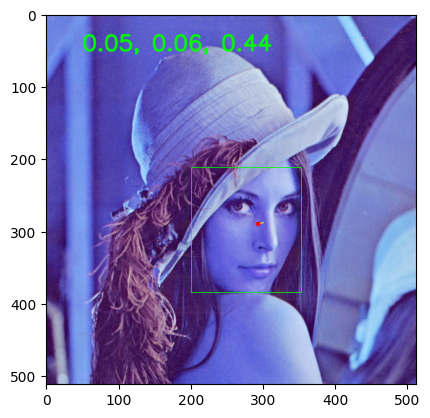

In [5]:
plt.imshow(demo.visualizer.image)

In [6]:
x, y, z = face.head_position
gx, gy, gz = face.gaze_vector

# z + gz * t = 0
t = -z / gz
screen_x = x + gx * t
screen_y = y + gy * t
screen_z = z + gz * t
print(f'Head Position : {x:.4f}, {y:.4f}, {z:.4f}')
print(f'Gaze Vector   : {gx:.4f}, {gy:.4f}, {gz:.4f}')
print(f'Point of Gaze : {screen_x:.4f}, {screen_y:.4f}, {screen_z:.4f}')

Head Position : 0.0498, 0.0602, 0.4356
Gaze Vector   : -0.2177, -0.0234, -0.9757
Point of Gaze : -0.0474, 0.0498, 0.0000
